## Inference Demoe
The goal of this notebook is to illustrate how a trained, p2p network can be used to generate novel perspectives of a target face.

### Imports and local paths

In [1]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import circle, line, line_aa, polygon

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, flip_input=False, device='cuda:2')

In [2]:
sys.path.insert(0, '/home/mlomnitz/3-D_DataAugmentation/')

In [3]:
import p2p

### Meta data
Load the metadata so we can run an example using data from the validation split

In [4]:
p2p_df = pd.read_csv('../p2p_index.csv')
p2p_df = p2p_df[p2p_df['n_frames'] == 10]
train = p2p_df[p2p_df['set'] == 'train']
test = p2p_df[p2p_df['set'] == 'test']

In [5]:
test.iloc[100]

Unnamed: 0                      920
Unnamed: 0.1                    920
name            id00019/WqlypvicTmY
snippet                   00105.mp4
n_frames                         10
set                            test
Name: 857, dtype: object

In [6]:
np.random.randint(6)

5

### Get Image
Simple helper routine to return a random or specified image given a dataframe with the metadata

In [7]:
def get_image(df, idx=None, frame=None):
    if idx is None:
        idx = np.random.randint(len(df)+1)
    entry = df.iloc[idx]
    if frame is None:
        frame = np.random.randint(5)
    print('Retrieving {} frame {}'.format(idx, frame))
    data_path = '/home/mlomnitz/pose2pose/data/p2p/{}/{}/frame_{}.jpg'.format(entry['name'], 
                                                                              entry['snippet'],
                                                                              frame
                                                                             )
    return Image.open(data_path)

In [8]:
img = get_image(test, 129592, 3)

Retrieving 129592 frame 3


([], <a list of 0 Text yticklabel objects>)

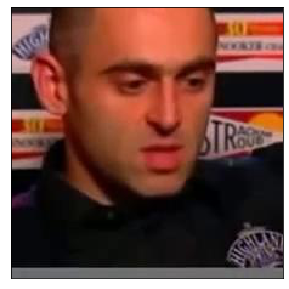

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.xticks([])
plt.yticks([])


### Landmarks and poses
Get the face landmarks associated to the face using face-alignment network and write simple routing to encode the landmarks into a "pose" that can be used with our p2p generator

In [10]:
t_frame = transforms.ToTensor()(img)
preds = fa.get_landmarks(np.array(img))

In [11]:
print(preds[0].shape)

(68, 3)


In [12]:
from p2p.utils import COLORS, pose_joints

def draw_pose_from_cords(face_preds, img_size, radius=2, draw_joints=True):
    colors = np.zeros(shape=img_size + (3, ), dtype=np.uint8)
    mask = np.zeros(shape=img_size, dtype=bool)
    preds = np.asarray(face_preds).reshape(68, 3).astype(np.uint8)
    for idx, v in enumerate(pose_joints.values()):
        #
        for i_pt in range(len(v)-1):
            yy, xx = line(preds[v[i_pt], 1], preds[v[i_pt], 0],
                          preds[v[i_pt+1], 1], preds[v[i_pt+1], 0])
            colors[yy, xx] = COLORS[idx]
            mask[yy, xx] = True
            yy, xx = circle(
                preds[v[i_pt], 1], preds[v[i_pt], 0], radius=radius, shape=img_size)
            colors[yy, xx] = COLORS[idx]
            mask[yy, xx] = True

        yy, xx = circle(preds[v[-1], 1], preds[v[-1], 0],
                        radius=radius, shape=img_size)
        colors[yy, xx] = COLORS[idx]
        mask[yy, xx] = True

    return colors, mask

In [13]:
colors, mask = draw_pose_from_cords(preds[0], (224, 224))

<ipython-input-12-241600ad2931>:14: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = circle(
<ipython-input-12-241600ad2931>:19: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = circle(preds[v[-1], 1], preds[v[-1], 0],


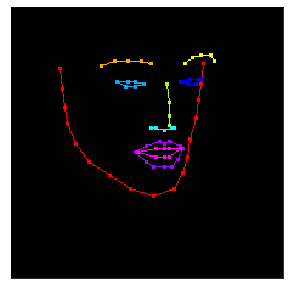

In [14]:
plt.figure(figsize=(5, 5))
plt.xticks([])
plt.yticks([])
plt.imshow(colors)

### More helper routines
Add some other helper routines to QA the different steps.  
- Plot the predicted landmarks with labels
- Plot the prediceted landmarks alone
- Superimpose the landmarks on the original frame

In [15]:
def test_preds(preds,img_size):
    fig = plt.figure(figsize=(9,9))
    for v in pose_joints.values():
        plt.plot(preds[v, 0], preds[v, 1], 'blue')
    for idx, point in enumerate(preds):
        plt.text(point[0], point[1], '{}'.format(idx))
#         plt.plot(preds[v, 0], preds[v, 1])
    plt.xlim(0, 224)
    plt.ylim(224, 0)
#     ax.set_zlim(224,0)
    plt.show()
    


def plot_preds(preds,img_size):
    fig = plt.figure(figsize=(5,5))
    for v in pose_joints.values():
        plt.plot(preds[v, 0], preds[v, 1], 'blue')
#         plt.plot(preds[v, 0], preds[v, 1])
    plt.xlim(0, 224)
    plt.ylim(224, 0)
    plt.xticks([])
    plt.yticks([])
#     ax.set_zlim(224,0)

def plot_superimposed(frame, preds):
    fig = plt.figure(figsize=(5,5))
    plt.imshow(frame)
    for v in pose_joints.values():
        plt.plot(preds[v, 0], preds[v, 1], 'blue')
#         plt.plot(preds[v, 0], preds[v, 1])

    plt.xticks([])
    plt.yticks([])    


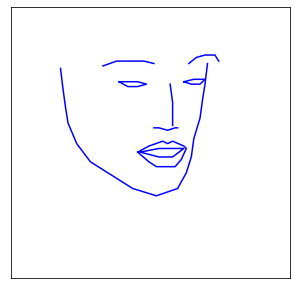

In [16]:
plot_preds(preds[0], (224, 224))

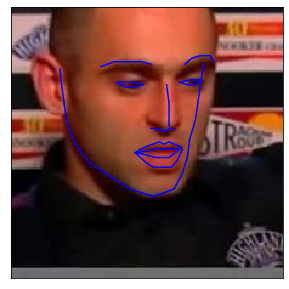

In [17]:
plot_superimposed(img, preds[0])

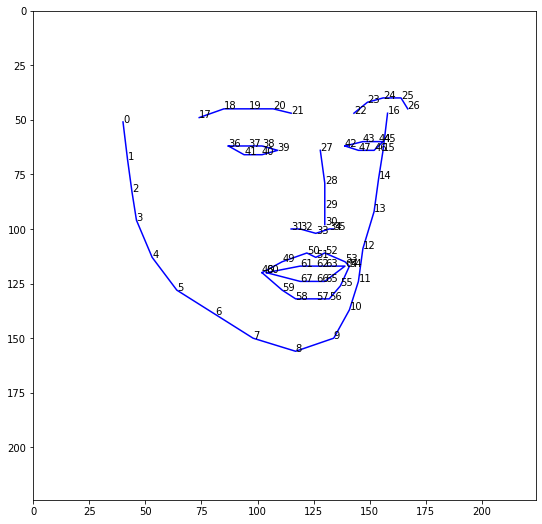

In [18]:
test_preds(preds[0], (224, 224))

### Helper functions for target poses
Functions to rotate the landmarks to generate the target perspectives of the original face.  
- get_pivot (DEPRECATED): Defines rotation center using chin landmark.
- get_center: Returns average x, y, ans z value of the landmarks to be defined as rotation center
- rotate_landmarks: Rotates landmarks around center by a given matrix
- rotation: Calculates rotation matrix given trhee angles (in degrees) and rotates landmarks

In [19]:
def get_pivot(landmarks):
    # Chin
    x = landmarks[8, 0]
    y = landmarks[8, 1]
    z = landmarks[0, 2]
    return x, y, z

def get_center(landmarks):
    center = np.zeros((3))
    for idx in range(3):
        center[idx] = np.mean(landmarks[:, idx])
    return center

def rotate_landmarks(landmarks, rot_x, rot_y, rot_z):
#     x, y, z = get_pivot(landmarks)
    x, y, z, = get_center(landmarks)
    center = np.zeros(landmarks.shape)
    center[:, 0] = x
    center[:, 1] = y
    center[:, 2] = z
    new_ldmk = landmarks - center
    new_ldmk = rotation(new_ldmk, rot_x, rot_y, rot_z)
    return new_ldmk + center
    

def rotation(landmarks, rot_x, rot_y, rot_z):
#     landmarks = torch.rand(1,68,3)
    # landmarks = torch.tensor([1, 0,0]).float()
#     landmarks = landmarks.reshape(1, 68, 3)
    pi = np.pi
    rot_x = rot_x * pi / 180 # degrees to radians
    rot_y = rot_y * pi / 180 # degrees to radians
    rot_z = rot_z * pi / 180 # degrees to radians

    
    rot = np.array([[np.cos(rot_z)*np.cos(rot_y), 
                     np.cos(rot_z)*np.sin(rot_y)*np.sin(rot_x)-np.sin(rot_z)*np.cos(rot_x),
                     np.cos(rot_z)*np.sin(rot_y)*np.cos(rot_x)+ np.sin(rot_z)*np.sin(rot_x)],
                    [np.sin(rot_z)*np.cos(rot_y), 
                     np.sin(rot_z)*np.sin(rot_y)*np.sin(rot_x) + np.cos(rot_z)*np.cos(rot_x),
                     np.sin(rot_z)*np.sin(rot_y)*np.cos(rot_x) - np.cos(rot_z)* np.sin(rot_x)],
                    [-np.sin(rot_y),
                     np.cos(rot_y)*np.sin(rot_x),
                     np.cos(rot_y)*np.cos(rot_x)]])
    
    rot_landmarks = landmarks.copy()
    for i in range(landmarks.shape[0]):  

        rot_landmarks[i, :] = np.matmul(rot, landmarks[i,:])

    return rot_landmarks

In [20]:
new_preds = rotate_landmarks(preds[0], 15, 0, 0)

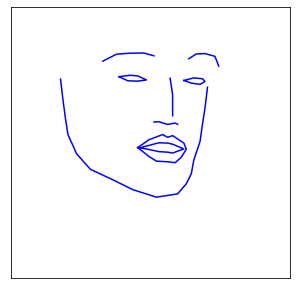

In [21]:
plot_preds(new_preds, (224, 224))

### Generate target landmarks
Generates a set of 25 target landmarks by rotation along x and y axis in 5 degree increments

In [22]:
def generate_landmarks(preds, max_rot=10):
    demo_ldmk = []
    for i_x in range(-2, 3):
        x_rot = i_x*max_rot
        for i_y in range(-2, 3):
            y_rot = i_y*max_rot
            demo_ldmk.append(rotate_landmarks(preds[0], x_rot, y_rot, 0))
    return demo_ldmk

In [23]:
demo = generate_landmarks(preds)
print(len(demo))

25


### Draw target grid

In [24]:
def make_full_fig(demo):
    fig = plt.figure(figsize=(16, 16))
    for i_plot in range(len(demo)):
        plt.subplot(5, 5, i_plot+1)
        this_ = demo[i_plot]
        for v in pose_joints.values():
            plt.plot(this_[v, 0], this_[v, 1], 'blue')
#         plt.plot(preds[v, 0], preds[v, 1])
            plt.xlim(0, 224)
            plt.ylim(224, 0)
            plt.xticks([])
            plt.yticks([])
        
    plt.show()

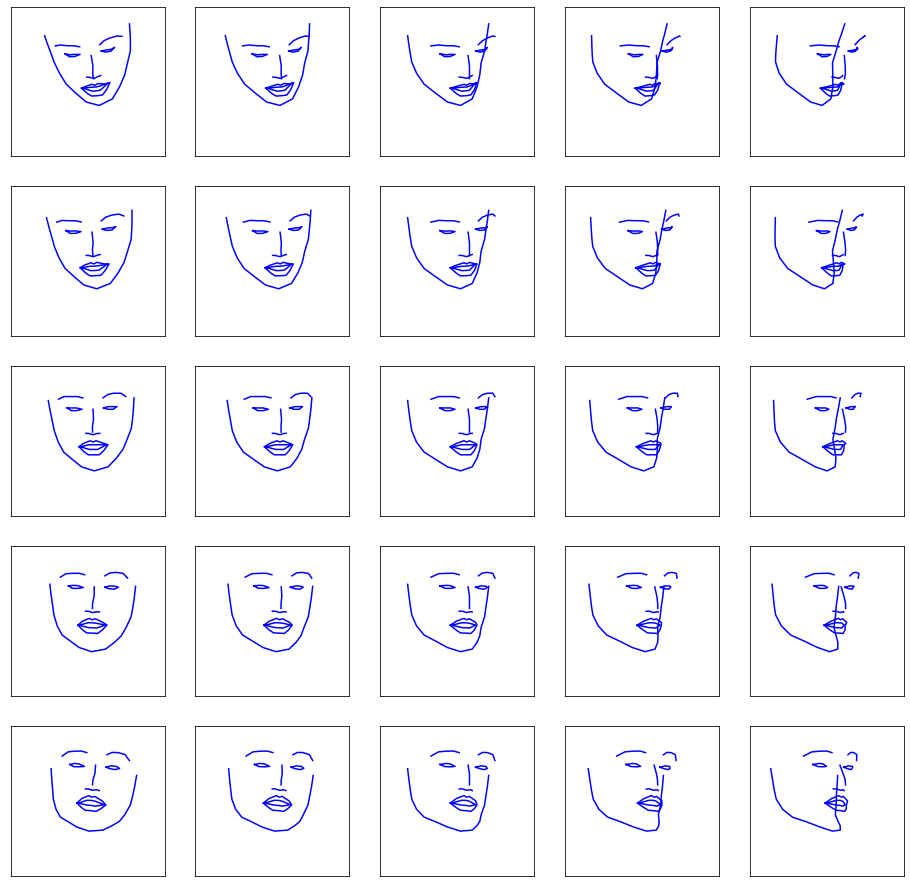

In [25]:
make_full_fig(demo)

In [15]:
import torch
import torchvision.transforms as transforms


In [16]:
aa = transforms.ToTensor()(colors)
print(aa.shape)

torch.Size([3, 224, 224])


### Prepare a batch of tensors for inference using initial image and the grid of generated landmarks

In [28]:
def make_demo_batch(demo, frame):
    poses = torch.zeros(len(demo), 3, 224, 224)
    for idx, pose in enumerate(demo):
        colors, mask = draw_pose_from_cords(pose, (224, 224))
        poses[idx] = transforms.ToTensor()(colors)
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
    frame0 = normalize(frame).unsqueeze(0).repeat(25, 1, 1, 1)
    
    return torch.cat([frame0, poses], dim=1)

                        
    
    
    

In [29]:
input_ = make_demo_batch(demo, t_frame)

<ipython-input-12-732df4f27f0c>:25: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = circle(
<ipython-input-12-732df4f27f0c>:30: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  yy, xx = circle(preds[v[-1], 1], preds[v[-1], 0],


### Build generator, load pretrained weights and run inference

In [30]:
generator = p2p.GlobalGenerator(input_nc=6, output_nc=3)
chpt = torch.load('../p2p/pretrained/VGG_mse/checkpoint_39.pth.tar')

In [31]:
generator.load_state_dict(chpt['generator'])

<All keys matched successfully>

In [32]:
print(generator)

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [33]:
chpt

{'generator': OrderedDict([('model.1.weight',
               tensor([[[[ 6.2286e-01,  5.3857e-01,  4.1309e-01,  ...,  3.2691e-01,
                           3.6071e-01,  3.0312e-01],
                         [ 2.8427e-01,  1.7850e-01,  4.4300e-02,  ...,  1.8172e-01,
                           2.0117e-01,  2.6975e-01],
                         [ 1.9052e-01, -1.6612e-01, -4.6050e-01,  ..., -2.0852e-02,
                           2.2422e-01,  3.2764e-01],
                         ...,
                         [ 1.9116e-01, -3.0088e-01, -6.6743e-01,  ..., -3.5410e-01,
                           2.1826e-02,  2.7547e-01],
                         [ 2.8830e-01, -1.3950e-01, -2.5171e-01,  ..., -1.8273e-01,
                           5.4850e-02,  3.0117e-01],
                         [ 4.5526e-01,  2.0316e-01,  1.3554e-01,  ...,  1.7087e-01,
                           2.6386e-01,  3.9639e-01]],
               
                        [[ 1.4431e+00,  1.0024e+00,  8.0709e-01,  ...,  8.4214e-01,
 

In [34]:

device = torch.device('cuda:0')
generator.to(device)
generator.eval()
with torch.no_grad():
    preds = generator(input_.to(device))

### Plot the predicted poses

In [35]:
from p2p.utils import prepare_image
def plot_predicted_poses(preds):
    fig = plt.figure(figsize=(16, 16))
    for idx in range(preds.shape[0]):
        pose = preds[idx].cpu()
        view_img = prepare_image(pose)
        plt.subplot(5, 5, idx+1)
        plt.imshow(view_img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

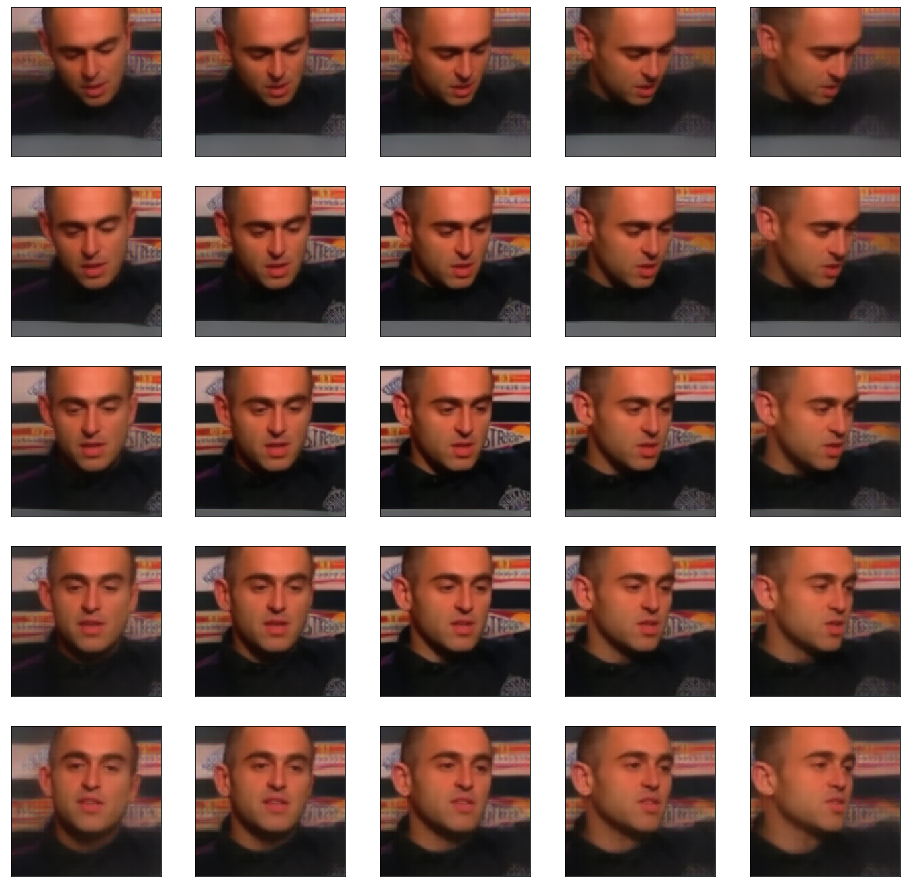

In [36]:
plot_predicted_poses(preds)